Input should be spectra of duplicates, able to be grouped by Sample_Name column.

In [1]:
import pandas as pd
import numpy as np
from statistics import median, mean
from matplotlib import pyplot as plt

from model_tools import *

'''
by Cai Ytsma (cai@caiconsulting.co.uk)
Last updated 27 September 2022

This program calculates the overall sensitivity of a 
dataset by calculating the standard deviation within
intensity values of duplicate spectra per channel and
averaging those values per sample (grouped by 'Sample_Name' column).

User decides whether to use median or mean sensitivity.

Overall and individual sensitivities are exported
in `sensitivity_results.csv`

It also calculates the relative uncertainty at each
channel and identifies those above a user-defined
upper percentile threshold. Average relative
uncertainty per channel, and a plot identifying
those channels above the threshold are exported.
'''

#-------------------#
# INPUT INFORMATION #
#-------------------#
data_folder, all_files = get_data_folder()
spectra_path = get_spectra_path(data_folder, all_files)
meta_path = get_meta_path(data_folder, all_files)
outpath = get_out_folder()

# import
spectra = pd.read_csv(spectra_path)
meta = pd.read_csv(meta_path)

# check data in same order
check = set(spectra.columns[1:]) == set(meta['pkey'].values)
if not check:
    raise ValueError('Spectra and metadata pkeys must be identical')
    
if 'Sample_Name' not in meta.columns:
    raise ValueError('Must have column "Sample_Name" to group duplicate spectra by')

Folder path containing data: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_data
Spectra filename: train_spectra
Metadata filename: train_meta
Folder path to export results: C:\Users\ytsma22c\Documents\GitHub\auto-modelling\test_results


Calculating relative uncertainty per channel
What should the upper percentile threshold be, for identifying channels with large relative uncertainty? 90


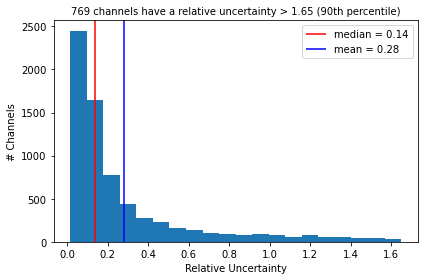

In [4]:
## step 1
print('Calculating relative uncertainty per channel')
rel_stdev_list = []

for sample in meta.Sample_Name.unique():
    pkey_list = meta[meta.Sample_Name == sample]['pkey'].values
    
    # skip if no duplicate spectra
    if len(pkey_list) < 2:
        continue
        
    dup_spectra = spectra[pkey_list]
    avg_intensity = spectra[pkey_list].mean(axis=1)
    all_stdev = dup_spectra.std(axis=1)
    rel_stdev = abs(all_stdev / avg_intensity).replace(np.inf, np.nan)
    
    rel_stdev_list.append(rel_stdev)

avg_channel_rel_stdev = pd.DataFrame(rel_stdev_list).mean(axis=0)

# calculate threshold value
percent = int(input('What should the upper percentile threshold be, for identifying channels with large relative uncertainty? '))
upper_threshold = np.percentile(avg_channel_rel_stdev, percent)

# cumulate
channel_df = pd.DataFrame({
  'wave':spectra['wave'],
  'avg_rel_stdev':avg_channel_rel_stdev
})
channel_df[f'below_{percent}th_percentile'] = ['yes' if f <= upper_threshold else 'no' for f in channel_df['avg_rel_stdev']]
# export
channel_df.to_csv(f'{outpath}\\average_relative_channel_uncertainty.csv', index=False)

# median and mean of those below
channel_df_below_thresh = channel_df[channel_df.avg_rel_stdev<=upper_threshold]
median_rel = median(channel_df_below_thresh.avg_rel_stdev)
mean_rel = mean(channel_df_below_thresh.avg_rel_stdev)

# histogram
channel_df_over_thresh = channel_df[channel_df.avg_rel_stdev>upper_threshold]
n_bad = len(channel_df_over_thresh)
n_all = len(channel_df)
title = f'{n_bad} channels have a relative uncertainty > {round(upper_threshold,2)} ({percent}th percentile)'

med_c = 'red'
mean_c = 'blue'

plt.hist(channel_df_below_thresh.avg_rel_stdev, bins=20)
plt.title(title, fontsize=10)
plt.ylabel("# Channels")
plt.xlabel("Relative Uncertainty")
y_bot, y_top = plt.ylim()
plt.vlines(x=median_rel,
           ymin = 0,
           ymax = y_top,
           colors=med_c,
           label=f'median = {round(median_rel,2)}')
plt.vlines(x=mean_rel,
           ymin = 0,
           ymax = y_top,
           colors=mean_c,
           label=f'mean = {round(mean_rel,2)}')
plt.ylim((0,y_top))
plt.legend()
# save plot
plt.tight_layout()
plt.savefig(f"{outpath}\\relative_uncertainty_channel_comparison.jpg", dpi=600)
plt.savefig(f"{outpath}\\relative_uncertainty_channel_comparison.eps", dpi=600)
plt.close()

In [5]:
# identify channels in spectra with bad channels
bad_channels = channel_df_over_thresh['wave'].values

# example spectrum
plt.figure(figsize=(12,6))
plt.plot(spectra['wave'], spectra[spectra.columns[1]], color='black', linewidth=1)
y_bot, y_top = plt.ylim()
plt.vlines(x=bad_channels,
           ymin = 0,
           ymax = y_top,
           colors='red',
           linewidth=0.5,
           alpha=0.3)
plt.ylim((0,y_top))
plt.ylabel('Intensity')
plt.xlabel('Wave')
plt.title(f'Channels with relative uncertainties over {round(upper_threshold,2)} ({percent}th percentile)')
plt.tight_layout()
plt.savefig(f"{outpath}\\high_rel_uncertainty_channels_plot.jpg", dpi=600)
plt.savefig(f"{outpath}\\high_rel_uncertainty_channels_plot.eps", dpi=600)
plt.close()

Calculating overall sensitivity


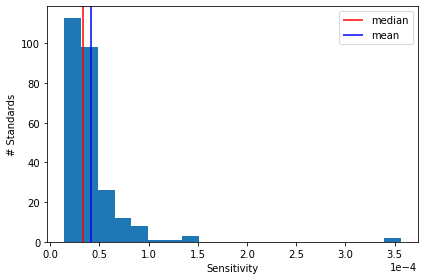

In [6]:
## DONT remove those above threshold because all used for training
#clean_spectra = spectra[~spectra['wave'].isin(bad_channels)]

print('Calculating overall sensitivity')
# get sensitivity per sample
sens_list = []
sample_list = []
n_dup_list = []

for sample in meta.Sample_Name.unique():
    pkey_list = meta[meta.Sample_Name == sample]['pkey'].values
    
    # skip if no duplicate spectra
    if len(pkey_list) < 2:
        continue
        
    dup_spectra = spectra[pkey_list]
    avg_stdev = dup_spectra.std(axis=1).mean()
    
    sample_list.append(sample)
    sens_list.append(avg_stdev)
    n_dup_list.append(len(pkey_list))

sample_df = pd.DataFrame({
    'Sample_Name':sample_list,
    '# Duplicates':n_dup_list,
    'Sensitivity':sens_list
}).sort_values('Sample_Name')

# median and mean
median_sens = median(sens_list)
mean_sens = mean(sens_list)

# histogram
plt.hist(sens_list, bins=20)
plt.ylabel("# Standards")
plt.xlabel("Sensitivity")
y_bot, y_top = plt.ylim()
plt.vlines(x=median_sens,
           ymin = 0,
           ymax = y_top,
           colors=med_c,
           label='median')
plt.vlines(x=mean_sens,
           ymin = 0,
           ymax = y_top,
           colors=mean_c,
           label='mean')
plt.legend()
plt.ylim((0,y_top))
plt.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
#plt.title(f'Only using channels with relative uncertainties below {percent}th percentile', fontsize=10)
# save plot
plt.tight_layout()
plt.savefig(f"{outpath}\\sensitivity_sample_comparison.jpg", dpi=600)
plt.savefig(f"{outpath}\\sensitivity_sample_comparison.eps", dpi=600)
# show plot
plt.show(block=False)

In [7]:
# choose which value to use
sens_prompt = "Use [1] median or [2] mean sensitivity? "
sens_choice = int(input(sens_prompt))
while sens_choice not in [1,2]:
    print("Error: input must be either 1 or 2")
    sens_choice = int(input(sens_prompt))
    
sensitivity = median_sens if sens_choice == 1 else mean_sens

# close figure
plt.close()

print('Chosen sensitivity is', sensitivity)

#---------#
# RESULTS #
#---------#

sens_info = f'''*Sensitivity Information*

Median sensitivity:,{median_sens}
Mean sensitivity:,{mean_sens}
Chosen value:,{'median' if sens_choice == 1 else 'mean'}

'''
# export
filename = f"{outpath}\\sensitivity_results.csv"
with open(filename, 'w', newline='\n') as file:
    file.write(sens_info)
# append variable info
with open(filename, 'a', newline='\n') as file:
    sample_df.to_csv(file, index=False)
    
print('Results exported')

Use [1] median or [2] mean sensitivity? 1
Chosen sensitivity is 3.3827294142211984e-05
Results exported
